In [1]:
import charts_function_list
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image

In [2]:
_,data,outputs = charts_function_list.folder_setup()
lego = os.path.join(data,'lego-database')
os.chdir(lego)

In [3]:
lego = os.path.join(data,'lego-database')
df_values = [x.split('.csv')[0] for x in os.listdir(lego)] 
df_values.remove('downloads_schema.png') #known non .csv

#set dictionary of all csvs
lego_d = {i:pd.read_csv(i+'.csv') for i in df_values}

In [4]:
#function to convert hex to rgb
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

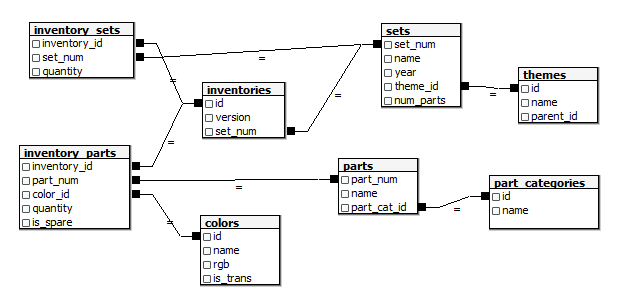

In [5]:
Image.open('downloads_schema.png')

### Idea 2 - 

* Do a size comparison of different piece categories
* or a wild crosstab with color

*create a color distribution of a few different common pieces
y axis can be the piece, x axis can be the colors, dot can be sized by how many



## Create new combined frames

In [67]:
pd.merge(set_1,lego_d["inventory_parts"],left_on='id',right_on='inventory_id',how='left')['year'].value_counts(dropna=False)

2016    49913
2015    48380
2014    41552
2013    34728
2012    31287
2017    27287
2011    25137
2010    24386
2009    22644
2008    21496
2006    18113
2007    17594
2003    17480
2004    16100
2005    15245
1998    13978
2002    13790
1999    11777
2001    10862
2000    10201
1997     9378
1996     9289
1995     7181
1994     6308
1993     6251
1991     5709
1990     4964
1985     4951
1986     4774
1987     4673
1992     4473
1989     4212
1988     3398
1980     3118
1978     2851
1979     2843
1976     2797
1984     2475
1983     2260
1977     2242
1981     2132
1982     1819
1973     1639
1975     1272
1974     1155
1969      992
1971      956
1972      886
1966      707
1968      603
1970      569
1967      481
1958      322
1962      214
1965      213
1955      194
1957      167
1964      164
1961      158
1963      135
1954       98
1956       84
1960       71
1950       46
1959       19
1953       18
Name: year, dtype: int64

In [6]:



combined_sets = pd.merge(lego_d["sets"],lego_d["inventories"],on='set_num',how='left')
combined_sets = pd.merge(combined_sets,lego_d["themes"],left_on='theme_id',right_on='id',how='left',suffixes=('_of_set','_of_theme'))

#combining parts and other tables
combined_parts = pd.merge(lego_d["inventory_parts"],lego_d["parts"],on='part_num',how='left') #merging this way. the reverse reveals some parts not in the inventory_parts
combined_parts = pd.merge(combined_parts, lego_d["part_categories"],left_on='part_cat_id',right_on='id',how='left',suffixes=('_of_part','_of_part_category'))
combined_parts = pd.merge(combined_parts,lego_d["colors"],left_on='color_id',right_on='id',how='left')
combined_parts = combined_parts.drop(['id_x','id_y'],axis=1)

#combine it all
master_lego = pd.merge(combined_sets,combined_parts,left_on='id_of_set',right_on='inventory_id',how='left')

In [127]:
#count of parts by color
part_count = master_lego.pivot_table('quantity',index='rgb',aggfunc='sum').reset_index()
part_count = pd.concat([part_count,pd.DataFrame(list(part_count.reset_index()['rgb'].apply(hex_to_rgb)),columns=['R','G','B'])],
          axis=1)

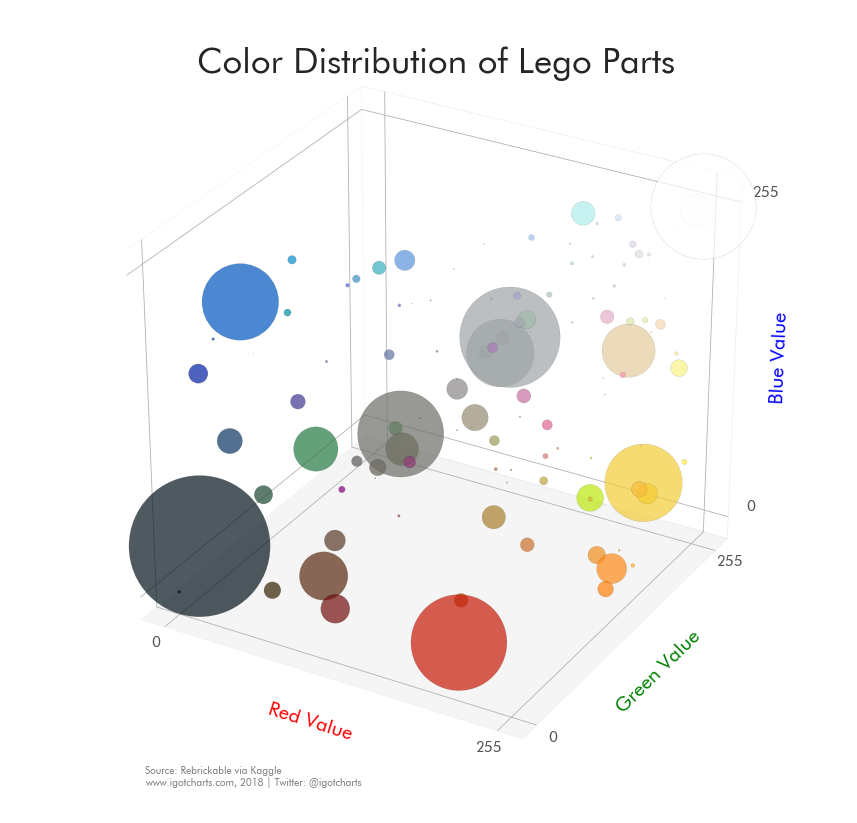

In [137]:
os.chdir(outputs)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,12))
fig.suptitle('Color Distribution of Lego Parts',size=35,color='#252525',x=.52)
fig.subplots_adjust(top=.99)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(part_count['R'],part_count['G'],part_count['B'],s=part_count['quantity']/20,c='#'+part_count['rgb'],alpha=.7,
           edgecolor='black',linewidth=.1)

#ax.scatter(255,255,255,s=part_count[part_count['rgb']=='FFFFFF']['quantity'].values/20,c='#FFFFFF',alpha=.8,
 #          edgecolor='black',linewidth=.5)

ax.set_xlabel('Red Value',fontsize=20,color='red')
ax.set_ylabel('Green Value',fontsize=20,color='green')
ax.set_zlabel('Blue Value',fontsize=20,color='blue')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = True
#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax.w_xaxis.set_ticks([0,255])
ax.w_yaxis.set_ticks([0,255])
ax.w_zaxis.set_ticks([0,255])
ax.w_xaxis.set_ticks_position('none') 

for t1 in ax.xaxis.get_ticklines():
    t1.set_visible(False)
    
for t1 in ax.yaxis.get_ticklines():
    t1.set_visible(False)
    
for t1 in ax.zaxis.get_ticklines():
    t1.set_visible(False)

ax.tick_params(labelsize=15,labelcolor='#525252',labeltop=True,
               labelbottom=False,labelleft=False,labelright=True,pad=8)
    
ax.text(-20,-20,-150,s='Source: Rebrickable via Kaggle',fontsize=10,color='#525252',alpha=.8)
ax.text(-20,-20,-160,s='www.igotcharts.com, 2018 | Twitter: @igotcharts',fontsize=10,color='#525252',alpha=.8)

charts_function_list.chart_save('lego_colors',dpi=150)

In [138]:
master_lego.to_csv('master_lego_data.csv')